# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [27]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


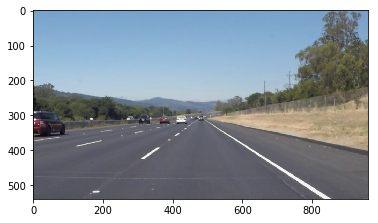

In [28]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [504]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_x = []
    left_x = []
    
    max_y = img.shape[0] - 1
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1) / (x2-x1)
            if m < 0:
                left_x += [x1, x2]
            else:
                right_x += [x1, x2]
    
    def get_average_x(x_values):
        return int(sum(x_values) / len(x_values))
                
    cv2.line(img, (max(right_x), max_y), (min(right_x), 295), [255, 0, 0], 8)
    cv2.line(img, (min(left_x), max_y), (max(left_x), 295), [255, 0, 0], 8)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [505]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

[]
[]
[1730.0744680851064]
[1730.0744680851064]
[1730.0744680851064, 1790.7272727272727]
[1730.0744680851064, 1790.7272727272727]
[1730.0744680851064, 1790.7272727272727, 1941.0319148936171]
[1730.0744680851064, 1790.7272727272727, 1941.0319148936171]
[1730.0744680851064, 1790.7272727272727, 1941.0319148936171]
[1730.0744680851064, 1790.7272727272727, 1941.0319148936171, 1783.7028571428573]
[1730.0744680851064, 1790.7272727272727, 1941.0319148936171, 1783.7028571428573]
[]
[]
[1757.955223880597]
[1757.955223880597, 1842.7152317880796]
[1757.955223880597, 1842.7152317880796]
[1757.955223880597, 1842.7152317880796]
[1757.955223880597, 1842.7152317880796, 1680.4897959183672]
[1757.955223880597, 1842.7152317880796, 1680.4897959183672]
[1757.955223880597, 1842.7152317880796, 1680.4897959183672]
[1757.955223880597, 1842.7152317880796, 1680.4897959183672, 1849.2302631578948]
[1757.955223880597, 1842.7152317880796, 1680.4897959183672, 1849.2302631578948]
[]
[1883.0046948356808]
[1883.004694835

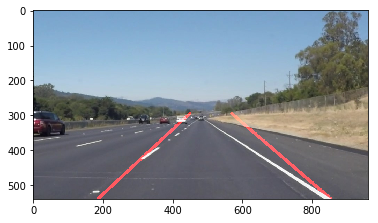

In [509]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
root_img_dir = "test_images/"
test_imgs = []
processed_imgs = []

for i in os.listdir(root_img_dir):
    test_imgs.append(mpimg.imread("{}{}".format(root_img_dir, i)))
    
# rho - distance resolution in pixels of the Hough grid
# theta - angular resolution in radians of the Hough grid
# threshold - minimum number of votes (intersections in Hough grid cell)
# min_line_length - minimum number of pixels making up a line
# max_line_gap - maximum gap in pixels between connectable line segments

max_vert = 330
vertices = np.array([[(60,t.shape[0]),(440, max_vert), (500, max_vert), (900,t.shape[0])]], dtype=np.int32)
data = {
    'kernel_size': 5, 
    'vertices': vertices, 
    'low': 50, 
    'high': 150, 
    'rho': 2,
    'theta': (np.pi/180),
    'threshold': 40, 
    'min_line_length': 100, 
    'max_line_gap': 130
}

def process(img, kernel_size, vertices, low, high, rho, theta, threshold, min_line_length, max_line_gap):
    low, high = canny_range_data
    rho, theta, threshold, min_line_length, max_line_gap = hough_data
    
    gs_img = grayscale(img)
    blurred_img = gaussian_blur(gs_img, kernel_size)
    canny_img = canny(blurred_img, low, high)
    masked_img = region_of_interest(canny_img, vertices)
    hough_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
    weighted = weighted_img(img, hough_img)

    return weighted

for t in test_imgs:
    processed_imgs.append(process(t, **data))

plt.imshow(processed_imgs[3])

##### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [351]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [352]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    kernel_size = 5

    low = 50
    high = 150

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 150 #minimum number of pixels making up a line
    max_line_gap = 100 # maximum gap in pixels between connectable line segments

    max_vert = 330
    vertices = np.array([[(60,image.shape[0]),(440, max_vert), (500, max_vert), (image.shape[1],image.shape[0])]], dtype=np.int32)
    canny_range_data = low, high
    hough_data = rho, theta, threshold, min_line_length, max_line_gap
    
    result = process(image, kernel_size, vertices, hough_data, canny_range_data)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [353]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

max_x: 446
min_x: 187
max_y: 515
min_y: 331
max_x: 869
min_x: 651
max_y: 538
min_y: 407
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  5%|▍         | 6/126 [00:00<00:02, 55.21it/s]

max_x: 446
min_x: 187
max_y: 515
min_y: 331
max_x: 869
min_x: 651
max_y: 538
min_y: 407
max_x: 445
min_x: 151
max_y: 539
min_y: 331
max_x: 868
min_x: 564
max_y: 539
min_y: 360
max_x: 444
min_x: 151
max_y: 538
min_y: 332
max_x: 846
min_x: 593
max_y: 539
min_y: 372
max_x: 377
min_x: 224
max_y: 494
min_y: 375
max_x: 867
min_x: 564
max_y: 539
min_y: 360
max_x: 870
min_x: 560
max_y: 539
min_y: 357
max_x: 443
min_x: 283
max_y: 444
min_y: 330
max_x: 870
min_x: 564
max_y: 538
min_y: 359
max_x: 442
min_x: 251
max_y: 463
min_y: 330
max_x: 871
min_x: 564
max_y: 538
min_y: 359
max_x: 442
min_x: 216
max_y: 491
min_y: 330
max_x: 872
min_x: 567
max_y: 538
min_y: 361
max_x: 871
min_x: 562
max_y: 539
min_y: 358
max_x: 449
min_x: 290
max_y: 441
min_y: 330
max_x: 865
min_x: 596
max_y: 539
min_y: 377
max_x: 453
min_x: 263
max_y: 461
min_y: 330
max_x: 860
min_x: 546
max_y: 539
min_y: 351
max_x: 447
min_x: 232
max_y: 484
min_y: 330
max_x: 856
min_x: 531
max_y: 538
min_y: 344


 14%|█▍        | 18/126 [00:00<00:01, 56.11it/s]

max_x: 446
min_x: 183
max_y: 516
min_y: 330
max_x: 855
min_x: 536
max_y: 538
min_y: 346
max_x: 445
min_x: 144
max_y: 539
min_y: 330
max_x: 834
min_x: 551
max_y: 539
min_y: 354
max_x: 444
min_x: 142
max_y: 539
min_y: 330
max_x: 857
min_x: 558
max_y: 539
min_y: 356
max_x: 859
min_x: 569
max_y: 538
min_y: 361
max_x: 860
min_x: 568
max_y: 539
min_y: 361
max_x: 442
min_x: 282
max_y: 439
min_y: 330
max_x: 858
min_x: 590
max_y: 538
min_y: 371
max_x: 441
min_x: 256
max_y: 459
min_y: 332
max_x: 856
min_x: 567
max_y: 538
min_y: 361
max_x: 449
min_x: 219
max_y: 485
min_y: 330
max_x: 854
min_x: 573
max_y: 538
min_y: 363
max_x: 853
min_x: 542
max_y: 539
min_y: 349
max_x: 448
min_x: 289
max_y: 439
min_y: 330
max_x: 854
min_x: 542
max_y: 539
min_y: 349
max_x: 447
min_x: 264
max_y: 457
min_y: 330
max_x: 853
min_x: 544
max_y: 538
min_y: 350
max_x: 447
min_x: 231
max_y: 479
min_y: 330
max_x: 854
min_x: 547
max_y: 538
min_y: 351


 25%|██▌       | 32/126 [00:00<00:01, 58.65it/s]

max_x: 446
min_x: 186
max_y: 509
min_y: 330
max_x: 855
min_x: 547
max_y: 539
min_y: 351
max_x: 444
min_x: 140
max_y: 539
min_y: 330
max_x: 853
min_x: 575
max_y: 537
min_y: 364
max_x: 444
min_x: 142
max_y: 538
min_y: 330
max_x: 855
min_x: 547
max_y: 538
min_y: 351
max_x: 856
min_x: 547
max_y: 538
min_y: 351
max_x: 856
min_x: 547
max_y: 539
min_y: 351
max_x: 437
min_x: 287
max_y: 441
min_y: 332
max_x: 856
min_x: 549
max_y: 538
min_y: 352
max_x: 440
min_x: 259
max_y: 459
min_y: 332
max_x: 857
min_x: 553
max_y: 539
min_y: 354
max_x: 439
min_x: 218
max_y: 487
min_y: 332
max_x: 858
min_x: 555
max_y: 538
min_y: 355
max_x: 858
min_x: 555
max_y: 539
min_y: 355
max_x: 858
min_x: 553
max_y: 539
min_y: 354
max_x: 444
min_x: 267
max_y: 455
min_y: 330
max_x: 855
min_x: 547
max_y: 539
min_y: 351
max_x: 447
min_x: 235
max_y: 478
min_y: 330
max_x: 854
min_x: 548
max_y: 539
min_y: 352
max_x: 446
min_x: 191
max_y: 509
min_y: 330
max_x: 855
min_x: 552
max_y: 539
min_y: 355


 35%|███▍      | 44/126 [00:00<00:01, 56.67it/s]

max_x: 446
min_x: 147
max_y: 539
min_y: 330
max_x: 854
min_x: 566
max_y: 539
min_y: 361
max_x: 445
min_x: 144
max_y: 539
min_y: 330
max_x: 854
min_x: 560
max_y: 539
min_y: 359
max_x: 854
min_x: 558
max_y: 538
min_y: 356
max_x: 855
min_x: 560
max_y: 538
min_y: 357
max_x: 441
min_x: 284
max_y: 442
min_y: 332
max_x: 855
min_x: 560
max_y: 538
min_y: 357
max_x: 441
min_x: 257
max_y: 460
min_y: 332
max_x: 854
min_x: 558
max_y: 538
min_y: 356
max_x: 439
min_x: 221
max_y: 484
min_y: 331
max_x: 855
min_x: 564
max_y: 538
min_y: 359
max_x: 854
min_x: 558
max_y: 539
min_y: 356
max_x: 855
min_x: 562
max_y: 538
min_y: 358
max_x: 435
min_x: 271
max_y: 448
min_y: 334
max_x: 855
min_x: 564
max_y: 539
min_y: 359


 40%|███▉      | 50/126 [00:00<00:01, 45.76it/s]

max_x: 445
min_x: 240
max_y: 472
min_y: 330
max_x: 854
min_x: 566
max_y: 539
min_y: 360
max_x: 441
min_x: 197
max_y: 500
min_y: 330
max_x: 854
min_x: 558
max_y: 539
min_y: 356
max_x: 442
min_x: 140
max_y: 538
min_y: 331
max_x: 853
min_x: 558
max_y: 539
min_y: 356
max_x: 444
min_x: 139
max_y: 539
min_y: 331
max_x: 852
min_x: 558
max_y: 539
min_y: 356
max_x: 443
min_x: 138
max_y: 537
min_y: 330
max_x: 853
min_x: 562
max_y: 539
min_y: 358
max_x: 816
min_x: 558
max_y: 526
min_y: 356


 44%|████▍     | 56/126 [00:01<00:01, 48.63it/s]

max_x: 847
min_x: 558
max_y: 539
min_y: 356
max_x: 439
min_x: 255
max_y: 457
min_y: 332
max_x: 844
min_x: 558
max_y: 539
min_y: 356
max_x: 440
min_x: 218
max_y: 480
min_y: 330
max_x: 852
min_x: 571
max_y: 539
min_y: 362
max_x: 852
min_x: 546
max_y: 538
min_y: 351
max_x: 446
min_x: 286
max_y: 435
min_y: 331
max_x: 850
min_x: 544
max_y: 538
min_y: 350
max_x: 446
min_x: 260
max_y: 452
min_y: 330
max_x: 849
min_x: 553
max_y: 539
min_y: 355
max_x: 445
min_x: 226
max_y: 476
min_y: 330
max_x: 826
min_x: 542
max_y: 539
min_y: 349


 48%|████▊     | 61/126 [00:01<00:01, 47.57it/s]

max_x: 444
min_x: 181
max_y: 508
min_y: 330
max_x: 824
min_x: 544
max_y: 538
min_y: 350
max_x: 443
min_x: 132
max_y: 539
min_y: 330
max_x: 844
min_x: 540
max_y: 539
min_y: 348
max_x: 442
min_x: 132
max_y: 538
min_y: 331
max_x: 822
min_x: 538
max_y: 538
min_y: 347
max_x: 843
min_x: 536
max_y: 539
min_y: 346


 53%|█████▎    | 67/126 [00:01<00:01, 49.25it/s]

max_x: 842
min_x: 536
max_y: 539
min_y: 346
max_x: 447
min_x: 277
max_y: 439
min_y: 330
max_x: 821
min_x: 535
max_y: 539
min_y: 346
max_x: 437
min_x: 248
max_y: 458
min_y: 333
max_x: 823
min_x: 544
max_y: 538
min_y: 350
max_x: 436
min_x: 212
max_y: 482
min_y: 333
max_x: 825
min_x: 542
max_y: 539
min_y: 349
max_x: 846
min_x: 544
max_y: 538
min_y: 350
max_x: 446
min_x: 287
max_y: 433
min_y: 330
max_x: 844
min_x: 536
max_y: 539
min_y: 346
max_x: 441
min_x: 262
max_y: 449
min_y: 331
max_x: 825
min_x: 536
max_y: 539
min_y: 346


 57%|█████▋    | 72/126 [00:01<00:01, 48.48it/s]

max_x: 440
min_x: 230
max_y: 470
min_y: 330
max_x: 843
min_x: 538
max_y: 539
min_y: 347
max_x: 443
min_x: 187
max_y: 496
min_y: 330
max_x: 842
min_x: 536
max_y: 539
min_y: 346
max_x: 443
min_x: 128
max_y: 538
min_y: 330
max_x: 842
min_x: 536
max_y: 539
min_y: 346


 62%|██████▏   | 78/126 [00:01<00:01, 47.23it/s]

max_x: 441
min_x: 123
max_y: 539
min_y: 330
max_x: 841
min_x: 535
max_y: 538
min_y: 346
max_x: 420
min_x: 140
max_y: 539
min_y: 342
max_x: 841
min_x: 536
max_y: 539
min_y: 346
max_x: 819
min_x: 538
max_y: 538
min_y: 347
max_x: 441
min_x: 277
max_y: 436
min_y: 330
max_x: 839
min_x: 536
max_y: 539
min_y: 346
max_x: 837
min_x: 551
max_y: 538
min_y: 353
max_x: 436
min_x: 217
max_y: 477
min_y: 333
max_x: 835
min_x: 549
max_y: 539
min_y: 352
max_x: 835
min_x: 535
max_y: 539
min_y: 346
max_x: 433
min_x: 283
max_y: 429
min_y: 335
max_x: 834
min_x: 536
max_y: 539
min_y: 346


 71%|███████   | 89/126 [00:01<00:00, 46.74it/s]

max_x: 442
min_x: 257
max_y: 448
min_y: 330
max_x: 833
min_x: 536
max_y: 539
min_y: 346
max_x: 442
min_x: 227
max_y: 469
min_y: 330
max_x: 811
min_x: 536
max_y: 538
min_y: 346
max_x: 443
min_x: 182
max_y: 497
min_y: 330
max_x: 829
min_x: 536
max_y: 538
min_y: 346
max_x: 442
min_x: 122
max_y: 537
min_y: 331
max_x: 833
min_x: 537
max_y: 539
min_y: 347
max_x: 441
min_x: 117
max_y: 539
min_y: 332
max_x: 810
min_x: 538
max_y: 539
min_y: 347
max_x: 437
min_x: 138
max_y: 539
min_y: 334
max_x: 823
min_x: 536
max_y: 539
min_y: 346
max_x: 809
min_x: 536
max_y: 539
min_y: 346
max_x: 439
min_x: 274
max_y: 438
min_y: 331
max_x: 830
min_x: 538
max_y: 539
min_y: 347
max_x: 440
min_x: 247
max_y: 457
min_y: 331
max_x: 829
min_x: 536
max_y: 539
min_y: 346
max_x: 448
min_x: 212
max_y: 480
min_y: 330
max_x: 830
min_x: 558
max_y: 539
min_y: 356
max_x: 808
min_x: 540
max_y: 538
min_y: 348


 79%|███████▊  | 99/126 [00:01<00:00, 47.66it/s]

max_x: 447
min_x: 285
max_y: 433
min_y: 330
max_x: 829
min_x: 558
max_y: 539
min_y: 356
max_x: 434
min_x: 270
max_y: 449
min_y: 335
max_x: 830
min_x: 549
max_y: 539
min_y: 352
max_x: 447
min_x: 231
max_y: 468
min_y: 330
max_x: 831
min_x: 568
max_y: 539
min_y: 361
max_x: 442
min_x: 190
max_y: 494
min_y: 330
max_x: 832
min_x: 553
max_y: 539
min_y: 354
max_x: 446
min_x: 132
max_y: 532
min_y: 330
max_x: 831
min_x: 558
max_y: 538
min_y: 356
max_x: 446
min_x: 117
max_y: 539
min_y: 330
max_x: 832
min_x: 560
max_y: 539
min_y: 357
max_x: 441
min_x: 137
max_y: 539
min_y: 331
max_x: 833
min_x: 562
max_y: 539
min_y: 358
max_x: 812
min_x: 562
max_y: 539
min_y: 358
max_x: 441
min_x: 283
max_y: 433
min_y: 331
max_x: 832
min_x: 571
max_y: 538
min_y: 362


 87%|████████▋ | 109/126 [00:02<00:00, 45.78it/s]

max_x: 442
min_x: 257
max_y: 454
min_y: 332
max_x: 832
min_x: 559
max_y: 538
min_y: 357
max_x: 440
min_x: 220
max_y: 481
min_y: 334
max_x: 833
min_x: 553
max_y: 539
min_y: 354
max_x: 815
min_x: 571
max_y: 538
min_y: 362
max_x: 836
min_x: 577
max_y: 539
min_y: 365
max_x: 447
min_x: 268
max_y: 446
min_y: 330
max_x: 837
min_x: 562
max_y: 539
min_y: 358
max_x: 448
min_x: 238
max_y: 468
min_y: 330
max_x: 818
min_x: 564
max_y: 539
min_y: 359
max_x: 429
min_x: 198
max_y: 496
min_y: 338
max_x: 838
min_x: 582
max_y: 539
min_y: 367
max_x: 448
min_x: 142
max_y: 534
min_y: 330
max_x: 838
min_x: 558
max_y: 539
min_y: 356
max_x: 446
min_x: 132
max_y: 539
min_y: 330
max_x: 817
min_x: 558
max_y: 538
min_y: 356
max_x: 410
min_x: 153
max_y: 538
min_y: 352
max_x: 838
min_x: 559
max_y: 539
min_y: 357


 95%|█████████▌| 120/126 [00:02<00:00, 46.87it/s]

max_x: 819
min_x: 560
max_y: 538
min_y: 357
max_x: 446
min_x: 289
max_y: 436
min_y: 331
max_x: 842
min_x: 558
max_y: 538
min_y: 356
max_x: 443
min_x: 259
max_y: 453
min_y: 333
max_x: 823
min_x: 568
max_y: 539
min_y: 361
max_x: 441
min_x: 226
max_y: 475
min_y: 332
max_x: 823
min_x: 572
max_y: 538
min_y: 363
max_x: 845
min_x: 569
max_y: 538
min_y: 361
max_x: 825
min_x: 592
max_y: 539
min_y: 372
max_x: 450
min_x: 273
max_y: 444
min_y: 330
max_x: 847
min_x: 560
max_y: 538
min_y: 357
max_x: 450
min_x: 244
max_y: 465
min_y: 330
max_x: 848
min_x: 557
max_y: 538
min_y: 356
max_x: 449
min_x: 205
max_y: 492
min_y: 330
max_x: 849
min_x: 555
max_y: 538
min_y: 355


 99%|█████████▉| 125/126 [00:02<00:00, 44.15it/s]


max_x: 448
min_x: 152
max_y: 529
min_y: 330
max_x: 851
min_x: 557
max_y: 538
min_y: 356
max_x: 447
min_x: 151
max_y: 538
min_y: 331
max_x: 829
min_x: 557
max_y: 539
min_y: 356
max_x: 446
min_x: 131
max_y: 538
min_y: 332
max_x: 852
min_x: 557
max_y: 538
min_y: 356
max_x: 832
min_x: 564
max_y: 539
min_y: 359
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.43 s, sys: 530 ms, total: 1.96 s
Wall time: 3.25 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [354]:
HTML("""
<video width="960" autoplay height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [33]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:01<00:00, 63.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 900 ms, sys: 340 ms, total: 1.24 s
Wall time: 2.48 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [206]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-20
429
1176
476
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 4/251 [00:00<00:07, 33.34it/s]

-20
429
1176
476
-92
416
1830
491
-116
406
-237
529
1
410
1116
505
-50
438
1141
489
60
410
1312
463
-54
413
1121
487


  5%|▍         | 12/251 [00:00<00:07, 33.85it/s]

-130
421
-102081
499
-3
415
2325
496
-158
389
1217
458
-124
457
1192
470
-44
407
1163
494
-191
410
1221
471
-317
435
2005
508
4
409


  8%|▊         | 20/251 [00:00<00:06, 33.91it/s]

2359
500
-124
407
-212
540
-14
391
1275
472
-19
402
1344
456
-205
427
1155
514
-155
410
1256
483
65
418
8259
501


 10%|▉         | 24/251 [00:00<00:06, 33.51it/s]

-59
420
1237
464
-41
401
1215
483
16
406
1145
432
40
395
1175
462
-74
412
1082
474
30
396
1290
456
61
413
1281
445


 13%|█▎        | 32/251 [00:00<00:06, 33.49it/s]

15
406
1277
447
0
427
1480
463
33
411
2038
462
45
391
1161
471
-55
415
1281
449
53
414
1246
449
31
400
1227
455


 16%|█▌        | 40/251 [00:01<00:06, 31.45it/s]

-3
410
1283
494
-31
417
1301
479
-97
409
1149
487
-30
406
1279
462
-60
403
1173
464
-210
423
1472
479
-196
411
1347
447


 18%|█▊        | 44/251 [00:01<00:11, 17.75it/s]

-57
405
1254
444
13
410
1609
473
-22
421
1211
451
-76
440
1229
469
-58
420
1200
472


 19%|█▊        | 47/251 [00:01<00:13, 14.69it/s]

-201
404
1205
457
-28
399
1244
451


 20%|█▉        | 50/251 [00:02<00:27,  7.30it/s]

-192
418
1250
446



 21%|██        | 52/251 [00:03<00:24,  7.97it/s]

-160
408
1581
451
-58
404
1522
446
-203
416
1248
456


 22%|██▏       | 54/251 [00:03<00:22,  8.69it/s]

-339
425
1282
452
-215
401
1225
479


 23%|██▎       | 58/251 [00:03<00:18, 10.43it/s]

-55
407
1246
479
-128
386
1274
458
-117
394
1302
483
-150
398
1244
484


 25%|██▍       | 62/251 [00:03<00:16, 11.60it/s]

-266
402
1282
462
-106
402
1666
455
-197
398
1439
463


 26%|██▌       | 65/251 [00:03<00:13, 13.41it/s]

-193
400
1537
461
-87
370
1398
462
-232
394
1377
461
-313
399
1542
467


 27%|██▋       | 69/251 [00:04<00:13, 13.40it/s]

-306
378
1582
458
-273
384
1599
462
-2282
439
1377
476
-276


 29%|██▉       | 74/251 [00:04<00:10, 17.34it/s]

395
1505
465
-205
389
1541
466
-247
399
1454
459
-243
396
1739
468
-101
380
1691
461


 31%|███       | 77/251 [00:04<00:09, 19.07it/s]

-488
403
1744
457
-608
411
1693
465
-397
403
1699
472
-644
415
1568
479
-359
406
1855
481


 33%|███▎      | 83/251 [00:04<00:08, 19.85it/s]

-390
421
2007
467
-365
413
2240
474
-441
420
1360
504
-501
426
1432
504
-388
418
1616
503


 34%|███▍      | 86/251 [00:05<00:07, 20.67it/s]

-410
426
-8604
483
-430
427
-3074
501
-434
422
3618
520
-175
411
10287
486


 37%|███▋      | 92/251 [00:05<00:07, 21.86it/s]

-117
417
-36599
486
-153
420
-8135
499
-171
410
-531
494
-128
413
-1870
481
-146
423
-1685
493
-59
406
-1866
492


 39%|███▉      | 98/251 [00:05<00:06, 22.75it/s]

-134
423
3314
523
-185
411
2265
519
-197
429
61959
553
-166
437
-728
481
-166
427
2984
496


 41%|████▏     | 104/251 [00:05<00:06, 23.11it/s]

-233
420
-1261
448
-213
414
2393
463
-396
412
2249
427
-2831
445
1670
473
-9398
453
1290
471


 43%|████▎     | 107/251 [00:05<00:06, 20.85it/s]

-8956
477
1498
468
7390
484
1809
472
-62381
505
1261
508
2171
523
1218
485


 44%|████▍     | 110/251 [00:06<00:06, 21.54it/s]

1575
543
1287
535
1478
525
1179
515
3696
468
1151
474
11871
444
1263
475
-4867
450
2669
446


 46%|████▌     | 116/251 [00:06<00:06, 20.06it/s]

1867
475
1320
449
-2772
430
1469
455
-621
411
1180
467
-838
403
1425
457
-17338
459
1374
479


 49%|████▊     | 122/251 [00:06<00:06, 20.47it/s]

-1091
418
1458
474
-985
403
1476
478
-837
431
1268
467
-787
405
1341
471


 50%|████▉     | 125/251 [00:06<00:06, 20.21it/s]

-601
394
1439
470
-343
394
6285
440
-568
377
1547
415
-354
379
1527
422


 52%|█████▏    | 131/251 [00:07<00:05, 20.58it/s]

-358
377
1282
469
-988
417
1293
465
-656
387
2164
465
-203364
470
1361
489
-508
393
1462
484


 53%|█████▎    | 134/251 [00:07<00:06, 19.18it/s]

-523
406
1322
491
-606
413
1259
510
-283
372
1291
502
-664
382
1353
478


 56%|█████▌    | 140/251 [00:07<00:05, 20.82it/s]

-489
387
1477
476
-1207
401
1232
485
-1194
404
1216
505
-1229
403
1618
497
-1322
432
1456
500


 57%|█████▋    | 143/251 [00:07<00:05, 18.62it/s]

-530
429
2316
516
-1619
462
1932
522
-1631
455
1558
512


 59%|█████▉    | 148/251 [00:08<00:05, 19.62it/s]

-1845
474
1469
521
-2469
489
1558
544
-2654
517
1526
567
-3006
539
1824
592
-1961
535
6031
607


 60%|██████    | 151/251 [00:08<00:05, 19.15it/s]

-1489
547
2883
616
-3053
539
2039
591
-887
500
1493
555
-688
468
1744
533
-70
413
-3749
540


 63%|██████▎   | 157/251 [00:08<00:04, 20.83it/s]

15
402
2410
579
-104
427
-3410
568
-30
414
-3430
498
-124
397
1237
483
-46
414
1278
480


 64%|██████▎   | 160/251 [00:08<00:04, 20.86it/s]

-28
406
3003
470
-60
396
1174
437
-80
394
-558
487
3
380
1464
471
-176
406
1357
479


 66%|██████▌   | 166/251 [00:08<00:04, 19.31it/s]

-244
409
1655
441
-397
416
1671
443
-357
411
1330
459
-56
429
1264
489


 67%|██████▋   | 169/251 [00:09<00:04, 17.87it/s]

-2549
480
1129
487
-209
420
1295
476
-219
423
1808
478
-121
422
1352
486


 70%|██████▉   | 175/251 [00:09<00:03, 19.41it/s]

-185
434
1931
450
-1406
480
1234
512
-83
405
1192
478
-397
414
1219
495
-322
406
1235
471


 71%|███████   | 178/251 [00:09<00:03, 18.61it/s]

-1741
480
1265
471
-225
419
1251
492
-1588
473
1208
482
-74
411
1621
475


 73%|███████▎  | 183/251 [00:09<00:03, 17.48it/s]

-172
405
1412
474
-229
415
1443
483
-223
393
-634
459


 74%|███████▎  | 185/251 [00:10<00:03, 18.01it/s]

-404
416
1194
449
-168
404
1592
471
-212
419
1887
532
-224
413
1293
468
-129
412
1399
478


 76%|███████▌  | 190/251 [00:10<00:03, 15.75it/s]

-225
401
1313
456
-480
405
1251
480
-80
402
1231
450


 78%|███████▊  | 195/251 [00:10<00:03, 17.95it/s]

-388
402
1553
476
-320
407
1317
464
-273
410
1185
498
-184
399
1248
462


 78%|███████▊  | 197/251 [00:10<00:03, 15.62it/s]

-272
419
1099
440
-243
404
1250
454
-76
417
1158
455


 80%|████████  | 201/251 [00:11<00:03, 15.65it/s]

-273
408
1130
465
-289
420
1508
501
-201
409
1582
521
-150
400
1217
451


 81%|████████▏ | 204/251 [00:11<00:02, 17.59it/s]

-119
400
1168
447
-133
410
1173
492
-521
420
1297
397
-232
419

 83%|████████▎ | 209/251 [00:11<00:02, 15.63it/s]


1099
460
-165
400
1274
455
-313
424
1147
478
-180
403
1274
454


 84%|████████▍ | 212/251 [00:11<00:02, 16.78it/s]

-135
405
1213
473
-6925
482
-1658
541
-434
405
1191
464
-360
432
1203
472


 86%|████████▌ | 216/251 [00:11<00:02, 16.91it/s]

-260
404
1365
472
-183
402
1177
342
-134
407
1310
490
-2411
467
1307
474


 88%|████████▊ | 221/251 [00:12<00:01, 18.48it/s]

-230
426
1268
473
-409
421
1455
482
-272
416
1261
484
-220
415
1193
479
-81
397
1192
484
6
417


 89%|████████▉ | 224/251 [00:12<00:01, 20.11it/s]

1283
495
-206
421
1151
473
-315
416
1172
491
-168
406
1412
457


 91%|█████████ | 229/251 [00:12<00:01, 18.29it/s]

-37
416
1439
458
-161
415
1388
471
-96
409
1153
475
-146
402
1177
449


 92%|█████████▏| 232/251 [00:12<00:01, 18.46it/s]

-416
419
1202
452
-72
426
1156
454
-229
409
1120
464
-147
396
1171
446


 95%|█████████▍| 238/251 [00:13<00:00, 17.46it/s]

-95
403
1189
471
-2289
482
1135
477
-380
423
1227
464
-74
416
1152
468


 96%|█████████▋| 242/251 [00:13<00:00, 17.92it/s]

-333
404
1151
456
-1072
474
1163
456
-43
416
1144
447
-143
422
1219
448
-879
473
1095
482


 98%|█████████▊| 247/251 [00:13<00:00, 19.14it/s]

-289
403
1217
443
-67
417
1235
447
-123
398
1238
445
-479
407
1276
471
-228
413
1178
463


100%|██████████| 251/251 [00:13<00:00, 18.25it/s]

-186
406
1196
478
-144
414
1263
453
-107
419
1221
455


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.32 s, sys: 1.52 s, total: 7.84 s
Wall time: 15.3 s


In [207]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[(689, 429), (709, 441), (730, 453), (751, 465), (772, 477), (793, 489), (814, 501), (835, 514), (856, 526), (877, 538)]
10
538.275176055
296.890680878


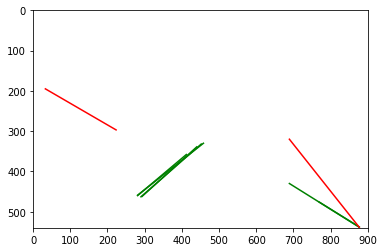

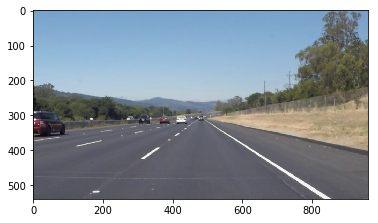

In [528]:
def new_hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    return lines

def process(img, kernel_size, vertices, low, high, rho, theta, threshold, min_line_length, max_line_gap):
    low, high = canny_range_data
    rho, theta, threshold, min_line_length, max_line_gap = hough_data
    
    gs_img = grayscale(img)
    blurred_img = gaussian_blur(gs_img, kernel_size)
    canny_img = canny(blurred_img, low, high)
    masked_img = region_of_interest(canny_img, vertices)
    
    return new_hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
    
lines = process(test_imgs[5], **data)

for line in lines:
    for x1, y1, x2, y2 in line:
        plt.plot((x1, x2), (y1, y2), 'g')

left_x = []
left_y = []
right_x = []
right_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        m = (y2-y1) / (x2-x1)
        if m < 0:
            left_x += [x1, x2]
            left_y += [y1, y2]
        else:
            right_x += [x1, x2]
            right_y += [y1, y2]

z = np.polyfit(right_x, right_y, 1)
f = np.poly1d(z)

x_new = np.linspace(min(right_x), max(right_x), 10).astype(int)
y_new = f(x_new).astype(int)
points_new = list(zip(x_new, y_new))

print(points_new) # [(25, 13), (28, 18), (31, 22), (34, 26), (37, 30), (40, 34), (43, 39), (46, 43), (49, 47), (52, 51)]
print(len(points_new)) # 10

# for x, y in points_new:
#     plt.plot(x, y, 'ro')
    
# for i in range(1, len(points_new)):
#     px, py = points_new[i-1]
#     cx, cy = points_new[i]
#     plt.plot((px, cx), (py, cy), 'r')

px, py = points_new[0]
cx, cy = points_new[-1]

# plt.plot((px, cx), (py, cy), 'r')
print(f(max(right_x)))
print(f(max(left_x)))
plt.plot((min(right_x), max(right_x)), (320, 540-1), 'r')
plt.plot((f(330), f(0)), (f(max(left_x)), f(min(left_x))), 'r')

plt.axis([0, 900, 540, 0])
plt.show()
plt.imshow(test_imgs[3])